In [2]:
!pip install protobuf==4.25.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatibl

In [3]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter
import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

2025-12-14 02:15:26.102048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765678526.491600      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765678526.608352      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# PATHS

train_dir = "../input/fer2013/train" 
test_dir = "../input/fer2013/test" 

img_size = 224   # ResNet50 yêu cầu 224x224
batch_size = 64
epochs = 12

In [5]:
# Mapping nhãn
class_names = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

def count_images(directory):
    counts = {}
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)
        if os.path.exists(class_folder):
            counts[class_name] = len([
                f for f in os.listdir(class_folder)
                if f.lower().endswith((".jpg", ".png", ".jpeg"))
            ])
        else:
            counts[class_name] = 0
    return counts

# Đếm
train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

print("=== TRAIN SET ===")
for k, v in train_counts.items():
    print(f"{k}: {v}")

print("\n=== TEST SET ===")
for k, v in test_counts.items():
    print(f"{k}: {v}")

=== TRAIN SET ===
angry: 3995
disgust: 436
fear: 4097
happy: 7215
sad: 4830
surprise: 3171
neutral: 4965

=== TEST SET ===
angry: 958
disgust: 111
fear: 1024
happy: 1774
sad: 1247
surprise: 831
neutral: 1233


In [6]:
# DATA AUGMENTATION + LOAD DATA
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="training"
)

validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation"
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# BUILD RESNET-50 MODEL

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)

# Freeze block đầu (giúp ổn định)
for layer in base_model.layers[:140]:
    layer.trainable = False

# Build custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

preds = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1765678563.162127      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765678563.162775      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,772,999 (94.50 MB)

 Trainable params: 16,161,799 (61.65 MB)

 Non-trainable params: 8,611,200 (32.85 MB)

In [8]:
# CALLBACKS
early = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "/kaggle/working/resnet50_fer.keras",
    monitor="val_accuracy",
    save_best_only=True
)

# ============================================================
# TRAIN MODEL
# ============================================================
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12


I0000 00:00:1765678583.539855     134 service.cc:148] XLA service 0x7cb76c002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765678583.541690     134 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765678583.541713     134 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765678586.127866     134 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765678600.187033     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.3289 - loss: 2.1581 - val_accuracy: 0.5231 - val_loss: 1.4195
Epoch 2/12
359/359 ━━━━━━━━━━━━━━━━━━━━ 303s 844ms/step - accuracy: 0.5168 - loss: 1.3604 - val_accuracy: 0.5656 - val_loss: 1.1834
Epoch 3/12
359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 828ms/step - accuracy: 0.5752 - loss: 1.1585 - val_accuracy: 0.5745 - val_loss: 1.1495
Epoch 4/12
359/359 ━━━━━━━━━━━━━━━━━━━━ 291s 810ms/step - accuracy: 0.6119 - loss: 1.0576 - val_accuracy: 0.5800 - val_loss: 1.1496
Epoch 5/12
359/359 ━━━━━━━━━━━━━━━━━━━━ 286s 796ms/step - accuracy: 0.6438 - loss: 0.9699 - val_accuracy: 0.5823 - val_loss: 1.1481
Epoch 6/12
359/359 ━━━━━━━━━━━━━━━━━━━━ 287s 800ms/step - accuracy: 0.6774 - loss: 0.8781 - val_accuracy: 0.6138 - val_loss: 1.0986
Epoch 7/12
359/359 ━━━━━━━━━━━━━━━━━━━━ 288s 802ms/step - accuracy: 0.6962 - loss: 0.8279 - val_accuracy: 0.6131 - val_loss: 1.1302
Epoch 8/12
359/359 ━━━━━━━━━━━━━━━━━━━━ 291s 810ms/step - accuracy: 0.7321 - loss: 0.7425 

In [9]:
# EVALUATE MODEL
# ============================================================
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"Train Acc = {train_acc * 100:.2f}%")
print(f"Val   Acc = {val_acc * 100:.2f}%")
print(f"Test  Acc = {test_acc * 100:.2f}%")

359/359 ━━━━━━━━━━━━━━━━━━━━ 274s 763ms/step - accuracy: 0.7499 - loss: 0.6977
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.6155 - loss: 1.0965
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 577ms/step - accuracy: 0.5935 - loss: 1.1513
Train Acc = 74.94%
Val   Acc = 61.38%
Test  Acc = 63.18%


In [10]:
#   RESNET-50 FINE-TUNE PHASE 2
# Unfreeze 50 layer cuối của ResNet-50
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Giảm learning rate khi fine-tune (rất quan trọng)
fine_tune_lr = 1e-5

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n=== BẮT ĐẦU FINE-TUNE RESNET-50 (PHASE 2) ===\n")
model.summary()

# Fine-train
fine_tune_epochs = 40   # bạn có thể tăng 30–40 nếu muốn

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=fine_tune_epochs,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        ModelCheckpoint("resnet50_fer_finetuned.keras", monitor='val_accuracy', save_best_only=True)
    ]
)

# Evaluate sau fine-tune
print("\n=== EVALUATE SAU FINE-TUNE ===\n")
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc     = model.evaluate(validation_generator)
test_loss, test_acc   = model.evaluate(test_generator)

print(f"Train Acc (fine-tune) = {train_acc*100:.2f}%")
print(f"Val Acc (fine-tune)   = {val_acc*100:.2f}%")
print(f"Test Acc (fine-tune)  = {test_acc*100:.2f}%")


=== BẮT ĐẦU FINE-TUNE RESNET-50 (PHASE 2) ===



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,772,999 (94.50 MB)

 Trainable params: 18,134,279 (69.18 MB)

 Non-trainable params: 6,638,720 (25.32 MB)

Epoch 1/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 358s 924ms/step - accuracy: 0.7075 - loss: 0.8015 - val_accuracy: 0.6255 - val_loss: 1.0704
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 317s 882ms/step - accuracy: 0.7423 - loss: 0.7172 - val_accuracy: 0.6297 - val_loss: 1.0926
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 301s 838ms/step - accuracy: 0.7561 - loss: 0.6688 - val_accuracy: 0.6326 - val_loss: 1.0886
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 299s 832ms/step - accuracy: 0.7752 - loss: 0.6178 - val_accuracy: 0.6344 - val_loss: 1.1015
Epoch 5/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 307s 854ms/step - accuracy: 0.7816 - loss: 0.6013 - val_accuracy: 0.6346 - val_loss: 1.1170
Epoch 6/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 826ms/step - accuracy: 0.7907 - loss: 0.5774 - val_accuracy: 0.6337 - val_loss: 1.1261
Epoch 7/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 318s 886ms/step - accuracy: 0.8078 - loss: 0.5347 - val_accuracy: 0.6319 - val_loss: 1.1414
Epoch 8/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 300s 835ms/step - accuracy: 0.8140 -

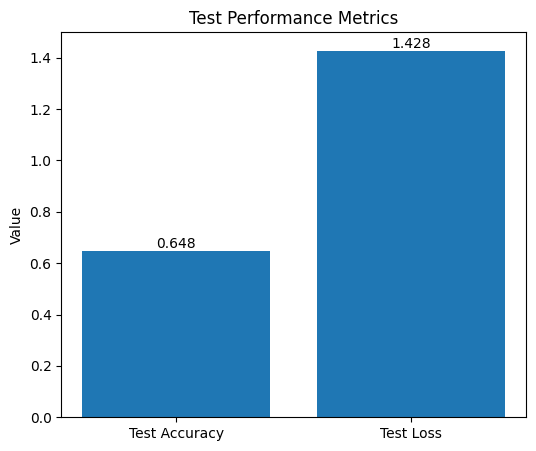

In [11]:
metrics = {
    "Test Accuracy": test_acc,
    "Test Loss": test_loss
}

plt.figure(figsize=(6,5))
plt.bar(metrics.keys(), metrics.values())
plt.title("Test Performance Metrics")
plt.ylabel("Value")

# Hiển thị giá trị trên cột
for i, v in enumerate(metrics.values()):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")

plt.show()

In [12]:
# PREDICTIONS
test_generator.reset()
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.52      0.57       958
     disgust       0.61      0.46      0.53       111
        fear       0.50      0.49      0.50      1024
       happy       0.83      0.84      0.83      1774
     neutral       0.56      0.67      0.61      1233
         sad       0.54      0.50      0.52      1247
    surprise       0.77      0.79      0.78       831

    accuracy                           0.65      7178
   macro avg       0.63      0.61      0.62      7178
weighted avg       0.65      0.65      0.65      7178



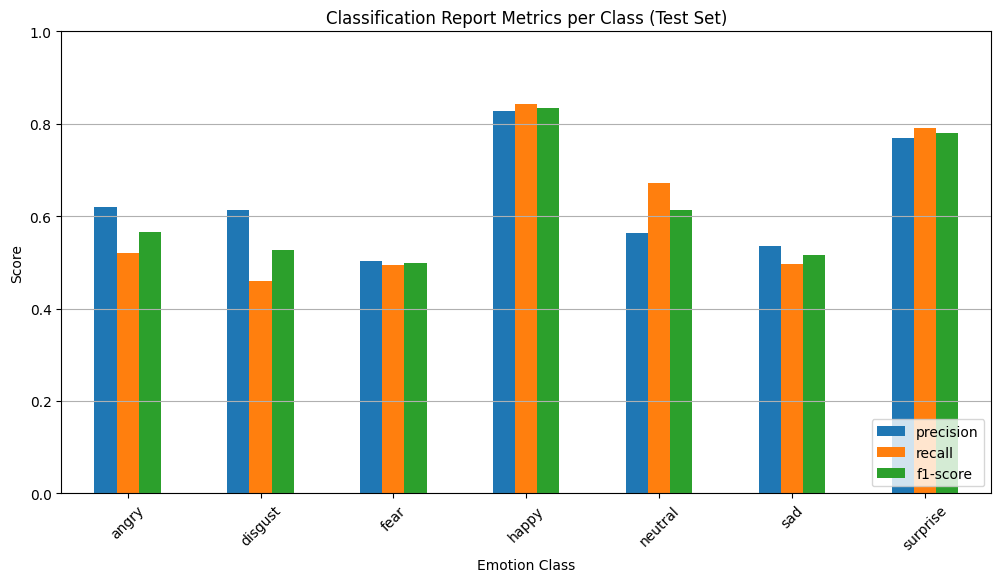

In [13]:
report_dict = classification_report(
    true_classes,
    pred_classes,
    target_names=class_labels,
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()

# Chỉ lấy các lớp (bỏ accuracy, macro avg, weighted avg)
df_classes = df_report.iloc[:len(class_labels)][["precision", "recall", "f1-score"]]

df_classes.plot(
    kind="bar",
    figsize=(12,6)
)

plt.title("Classification Report Metrics per Class (Test Set)")
plt.ylabel("Score")
plt.xlabel("Emotion Class")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.legend(loc="lower right")
plt.show()

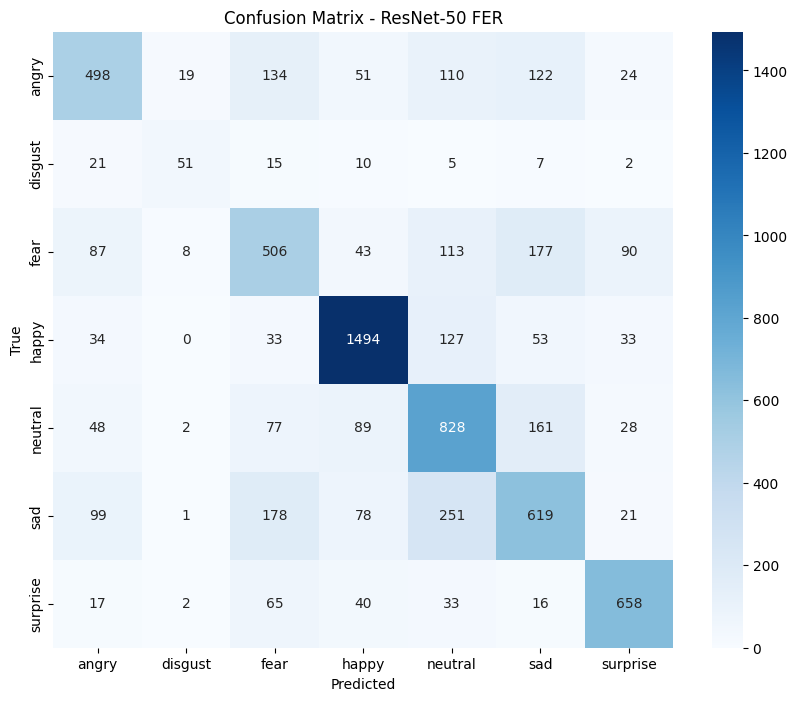

In [14]:
# CONFUSION MATRIX
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet-50 FER")
plt.show()

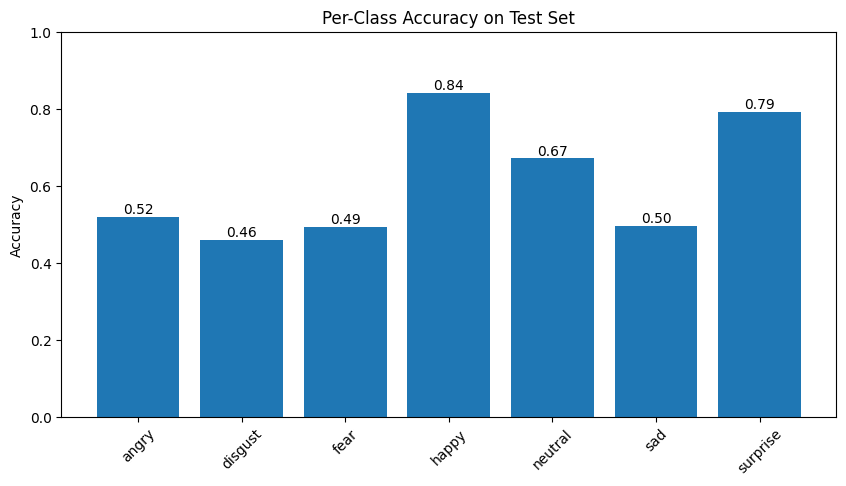

In [15]:
class_accuracy = {}

for i, class_name in enumerate(class_labels):
    idx = np.where(true_classes == i)
    acc = accuracy_score(true_classes[idx], pred_classes[idx])
    class_accuracy[class_name] = acc

plt.figure(figsize=(10,5))
plt.bar(class_accuracy.keys(), class_accuracy.values())
plt.title("Per-Class Accuracy on Test Set")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=45)

for i, v in enumerate(class_accuracy.values()):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.show()

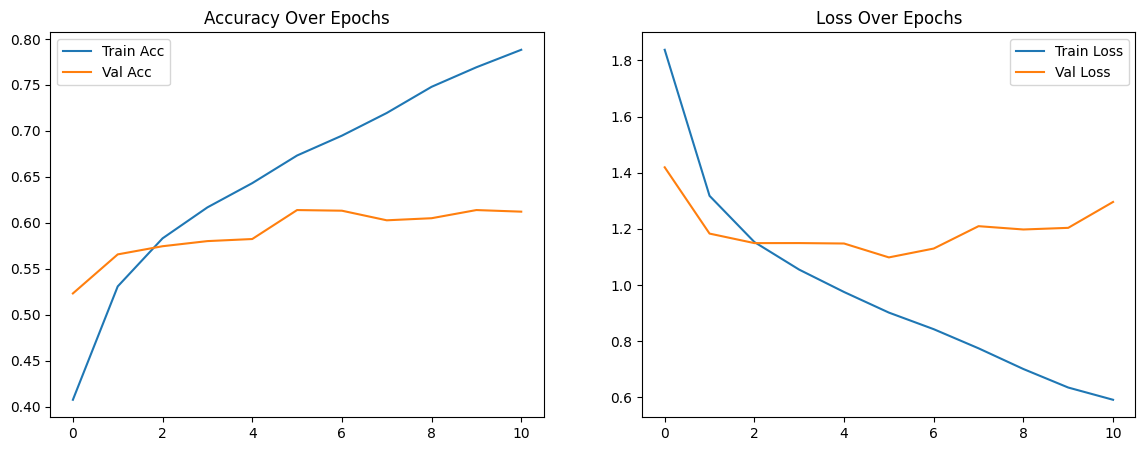

In [16]:

# ============================================================
# PLOT LOSS & ACCURACY
# ============================================================
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.show()

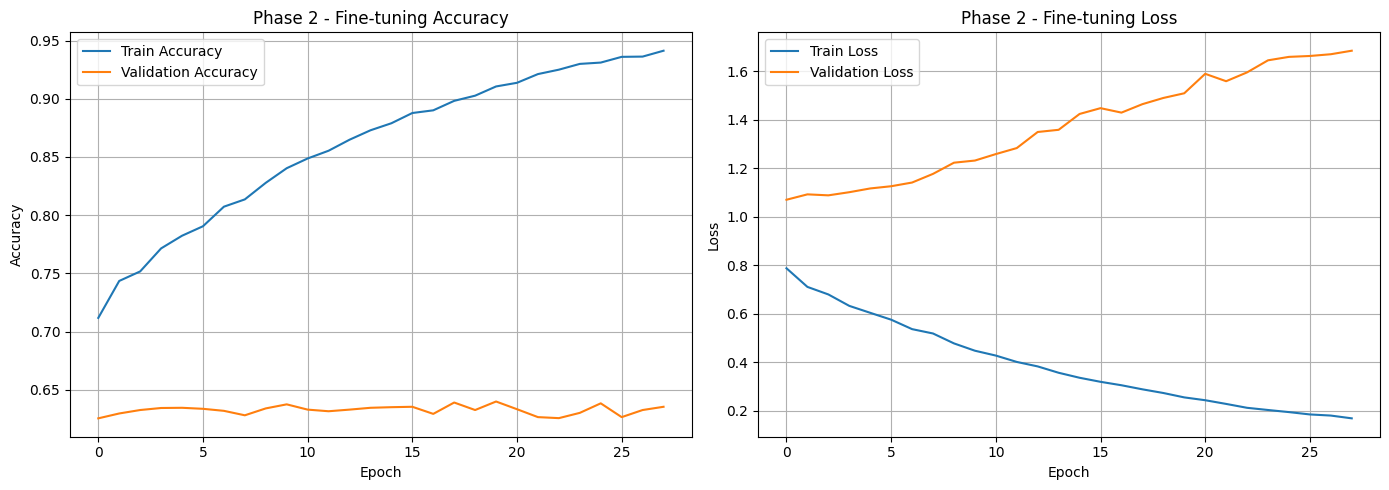

In [18]:
# ============================================================
# PLOT PHASE 2: FINE-TUNING RESNET50
# ============================================================
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history["accuracy"], label="Train Accuracy")
plt.plot(history_fine.history["val_accuracy"], label="Validation Accuracy")
plt.title("Phase 2 - Fine-tuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_fine.history["loss"], label="Train Loss")
plt.plot(history_fine.history["val_loss"], label="Validation Loss")
plt.title("Phase 2 - Fine-tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()